# Assignment 9: Causal Inference (Part 2)

## Objective:

Causal inference is the process of drawing a conclusion about a causal connection based on the conditions of the occurrence of an effect. It is a very powerful and widely-used tool in real-world applications and scenarios. In this assignment, you are expected to apply the basic concepts of causal inference to solve problems on real datasets and be able to achieve the following goals.

* Understand why causality is needed.
* Understand what is causality, particularly the difference between causality and correlation.
* Understand how to estimate counterfactual results.
* Understand how to use the graphical model to represent causality.
* Can use some tools (e.g., dowhy) to infer causality, express causality and estimate treatment effects.

# 0. Preparation

In [1]:
import numpy as np
import pandas as pd
from dataprep.eda import plot
pd.options.mode.chained_assignment = None

NumExpr defaulting to 8 threads.


In this assignment, you are going to use the [Lalonde](lalonde.csv) dataset. Each tuple in the dataset represents an individual who was enrolled (or not enrolled) in a job training program. It aims to evaluate the effectiveness of a job training program (the treatment variable) on the real earnings of an individual, after completing the program for years. 

The dataset consists of a number of demographic variables, like age, race, academic background, marriage status, and previous real earnings in 1974, 1975 as well as a treatment indicator, and the real earnings in the year 1978 (the outcome variable).

In [2]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head()
lalonde.head(-5)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...
PSID420,0,39,2,1,0,1,1,0.0,0.0,964.9555
PSID421,0,55,8,0,0,1,1,0.0,0.0,0.0000
PSID422,0,16,9,0,0,0,1,0.0,0.0,5551.8190


In [3]:
plot(lalonde)

GridBox(id='1391', ...)

## Task 1. Causal Graph 
In this task, you will draw a causal graph on a real-world dataset based on the information given. Please remind yourself of the difference between causality and correlation.

In [4]:
#import graphviz, the python tool we are going to use for this task
from graphviz import Digraph

In the Lalonde dataset, `treat` is the treatment attribute, which represents whether an individual was enrolled in the job training program or not. `re78` is the outcome attribute. `age` and `married` are confounding variables. Please draw the causal graph for these four attributes using Graphviz.

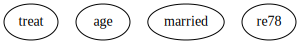

In [5]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot = Digraph(comment='The causal graph for Lalonde')
dot.node('a','treat')
dot.node('b','age')
dot.node('c','married')
dot.node('d','re78')

dot

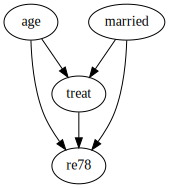

In [6]:
#Implement your plot function here and show the graph, the output should be a causal graph

dot.edge('b', 'a')
dot.edge('c', 'a')
dot.edge('a', 'd')
dot.edge('b', 'd')
dot.edge('c', 'd')

dot

## Task 2. ATE Estimation
In this task, your job is to implement different AET estimation approaches and draw useful conclusions.

### 2.1 Perfect Matching
For the PSID tuples in the dataset (i.e., those individuals who weren't enrolled in the job training program), please use perfect matching to estimate their salaries if they received treatments?


In [7]:
# Implement the perfect matching method here and output the count of PSID tuples whose counterfactual can be computed
# using perfect matching, as well as the percentage of such tuples among all PSID tuples. If there are multiple 
# tuples in the treatment group that can be matched with the control group, just select the first one
# output: count and percentage

df_control = lalonde.loc[lalonde['treat'] == 0]
df_treat = lalonde.loc[lalonde['treat'] == 1]

arr_matched = np.empty((0,2))

for idx, item in df_control.iterrows():
    treat = not item[0]
    age = item[1]
    educ = item[2]
    black = item[3]
    hispan = item[4]
    married = item[5]
    nodegree = item[6]
    re74 = item[7]
    re75 = item[8]
    
    df_match = df_treat.loc[(lalonde['treat'] == treat) &
                            (lalonde['age'] == age) &
                            (lalonde['educ'] == educ) &
                            (lalonde['black'] == black) &
                            (lalonde['hispan'] == hispan) &
                            (lalonde['married'] == married) &
                            (lalonde['nodegree'] == nodegree) &
                            (lalonde['re74'] == re74) &
                            (lalonde['re75'] == re75)]

    if (len(df_match) > 0):
        match_idx = df_match.index[0]
        match = np.array([[idx, match_idx]])
        arr_matched = np.append(arr_matched, match, axis=0)

count = len(arr_matched)
percentage = ((count * 100) / len(df_control))

In [8]:
# Run the following code to print out the result
print("Count of tuples which can be computed by perfect matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

Count of tuples which can be computed by perfect matching is 12
Percentage of such tuples among all PSID tuples is 2.797202797202797


In [9]:
# Compute ATE among those PSID tuples whose counterfactual can be computed using perfect matching
# output: value of ATE

ATE = 0

for idx1, idx2 in arr_matched:
    re78_control = lalonde.loc[idx1,'re78']
    re78_treat = lalonde.loc[idx2,'re78']
    ATE = ATE + (re78_treat - re78_control)

ATE = ATE / len(arr_matched)

In [10]:
# Run following code to print the result
print("ATE by perfect matching is " + str(ATE))

ATE by perfect matching is 1362.3939999999998


### 2.2 Nearest Neighbor Matching
For the PSID tuples in the dataset (i.e., those who weren't enrolled in the job training program), please use the nearest neighbor matching to estimate their salaries if they received treatments?

Please use all covariates (the attributes besides treatment and outcome) and use Euclidean distance as the distance metric.

In [34]:
# Implement the nearest neighbor matching method here and output the count of PSID tuples whose counterfactual can be
# computed using nearest neighbor matching, when the threshold is set to 1000, as well as the percentage of such tuples among all PSID tuples
# Output: count and percentage

# Please use np.linalg.norm(x1 - x2) to compute the euclidean distance between two vectors

df_control = lalonde.loc[lalonde['treat'] == 0]
df_treat = lalonde.loc[lalonde['treat'] == 1]

arr_matched = np.empty((0,2))

for idx, item in df_control.iterrows():
    features_base = item[1:-1]
    
    df_filter = df_treat.iloc[:,1:-1]
    
    arr_eucl_distance = np.linalg.norm(df_filter - features_base, axis=1)
    min_eucl_idx = np.argmin(arr_eucl_distance)
    min_eucl_val = np.min(arr_eucl_distance)
    
    if (min_eucl_val < 1000):
        idx_match = df_filter.iloc[min_eucl_idx:min_eucl_idx + 1, :].index.values[0]
        match = np.array([[idx, idx_match]])
        arr_matched = np.append(arr_matched, match, axis=0)

count = len(arr_matched)
percentage = ((count * 100) / len(df_control))

In [36]:
#run following code to print the result
print("Count of tuples which can be computed by nearest neighbor matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

Count of tuples which can be computed by nearest neighbor matching is 318
Percentage of such tuples among all PSID tuples is 74.12587412587412


In [37]:
# Compute ATE among those PSID tuples whose counterfactual can be computed using nearest neighbor matching
# Output: value of ATE

ATE = 0

for idx1, idx2 in arr_matched:
    re78_control = lalonde.loc[idx1,'re78']
    re78_treat = lalonde.loc[idx2,'re78']
    ATE = ATE + (re78_treat - re78_control)

ATE = ATE / len(arr_matched)

In [38]:
# Run following code to print out the result
print("ATE by nearest neighbor matching is " + str(ATE))

ATE by nearest neighbor matching is 519.1813407232701


### 2.3 Propensity Score Matching
For the PSID tuples in the dataset (i.e., those weren't enrolled in the job training program), please use propensity score matching to estimate their salaries if they received treatments?

Please use logistic regression to fit the propensity score.

In [39]:
# Compute propensity score P(y = 1|X) for each tuple in the dataset. Use logistic regression.
# Output: add the new column "psm" to lalonde dataframe

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')

x = lalonde.iloc[:,1:]
y = lalonde.iloc[:,0]

lr = lr.fit(x, y);

pred = lr.predict_proba(x)
lalonde['psm'] = pred[:,1]

In [40]:
lalonde.head(5)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,psm
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.455082
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.148304
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.732913
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.696610
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.694131


In [41]:
# For each tuple in the control group, find the matching tuple in the treatment group, and then compute
# the ATE over the population
# Please match tuples with the metric |psm1 - psm2| to be minimum, threhold set to 0.01
# Output: the value of ATE, the count of tuples that can be matched, as well as the percentage

df_treat = lalonde.loc[lalonde['treat'] == 1]
df_control = lalonde.loc[lalonde['treat'] == 0]

arr_matched = np.empty((0,2))

for idx, item in df_control.iterrows():
    features_base = item[-1:]
    
    df_filter = df_treat.iloc[:,-1:]
    
    arr_distance = np.array(abs(df_filter - features_base))
    min_idx = np.argmin(arr_distance)
    min_val = np.min(arr_distance)
    
    if (min_val < 0.01):
        idx_match = df_filter.iloc[min_idx:min_idx + 1, :].index.values[0]
        match = np.array([[idx, idx_match]])
        arr_matched = np.append(arr_matched, match, axis=0)

count = len(arr_matched)
percentage = ((count * 100) / len(df_control))

ATE = 0

for idx1, idx2 in arr_matched:
    re78_control = lalonde.loc[idx1,'re78']
    re78_treat = lalonde.loc[idx2,'re78']
    ATE = ATE + re78_treat - re78_control

ATE = ATE / len(arr_matched)

In [42]:
# Run the following code to print out the result
print("ATE by propensity score matching is " + str(ATE))
print("Count of tuples which can be computed by propensity score matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

ATE by propensity score matching is -441.62617891246873
Count of tuples which can be computed by propensity score matching is 377
Percentage of such tuples among all PSID tuples is 87.87878787878788


### 2.4 Linear Regression
Train two individual models to fit P(y|t = 1,X) and P(y|t = 0,X), then infer the counterfactual outcome using two models while setting treatment to the opposite value. Infer the ATE over the population.

In [43]:
# Train two individual linear regression models and infer the counterfactual result for each tuple
# Output: the value of ATE, over the population

from sklearn.linear_model import LinearRegression

if ('psm' in list(lalonde.columns)):
    lalonde.drop('psm', axis=1, inplace=True)

df_treat = lalonde[lalonde['treat'] == 1]
df_control = lalonde[lalonde['treat'] == 0]

treat_x = df_treat.iloc[:, 1:-1]
treat_y = df_treat.iloc[:,-1:]

control_x = df_control.iloc[:,1:-1]
control_y = df_control.iloc[:,-1:]

treat_reg = LinearRegression()
control_reg = LinearRegression()

treat_reg = treat_reg.fit(treat_x, treat_y)
control_reg = control_reg.fit(control_x, control_y)

control_predict = treat_reg.predict(control_x)
treat_predict = control_reg.predict(treat_x)

df_treat['pred'] = treat_predict
df_control['pred'] = control_predict

df_treat['diff'] = df_treat['re78'] - df_treat['pred']
df_control['diff'] = df_control['pred'] - df_control['re78']

ATE = (df_control['diff'].sum() + df_treat['diff'].sum()) / (len(df_control) + len(df_treat))

In [44]:
# Run following code to print out the result
print("ATE by linear regression is " + str(ATE))

ATE by linear regression is 1074.9085413955363


Please briefly discuss the advantages and disadvantages of the above four approaches.

**A.** Perfect matching only finds a small number of matches. The nearest neighbor matching method brings us the benefit to find more matches, but setting a good threshold is very important. Otherwise, it returns a very bad match. Propensity score matching needs more computational resources, however linear regression is easy to compute and needs less resources.

## Task 3. DoWhy
In this task, you are required to apply DoWhy and analyze the dataset using two ATE estimation methods.

In [45]:
from dowhy import CausalModel
model = CausalModel(data = lalonde,
                    treatment='treat',
                    outcome='re78',
                    common_causes=['nodegree', 'black', 'hispan', 'age', 'educ', 'married'])

Causal Graph not provided. DoWhy will construct a graph based on data inputs.
If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
Model to find the causal effect of treatment ['treat'] on outcome ['re78']


In [46]:
# Use the linear regression and PSM methods provided by DoWhy to estimate ATE 
# Output: ATE_linear, ATE_psm

lalonde['treat'] = lalonde['treat'].astype(bool)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
#print(identified_estimand)

causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
ATE_linear = causal_estimate.value

causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
ATE_psm = causal_estimate.value

Common causes of treatment and outcome:['black', 'educ', 'married', 'U', 'hispan', 'age', 'nodegree']
If this is observed data (not from a randomized experiment), there might always be missing confounders. Causal effect cannot be identified perfectly.
Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
Instrumental variables for treatment and outcome:[]
INFO: Using Linear Regression Estimator
b: re78~treat+black+educ+married+hispan+age+nodegree
INFO: Using Propensity Score Matching Estimator
b: re78~treat+black+educ+married+hispan+age+nodegree
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\dowhy\causal_estimators\propensity_score_matching_estimator.py:62: FutureWarning: `item` has been deprecated and wil

In [47]:
# Run following code to print out the result
print("ATE by linear regression is " + str(ATE_linear))
print("ATE by psm is " + str(ATE_psm))

ATE by linear regression is 1163.9223548829095
ATE by psm is 442.68176307817583


Briefly explain why the result by DoWhy is not same as the result by your own implementation.

**A.** The reason is probably because of the causal graph that dowhy creates automatically. The library may include or not include some variables in the causal graph based on the inference it does. As a result, the output is completely different from what we did.

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 9.